In [2]:
import h5py
import numpy as np
import copy
import math
import numpy.linalg as la
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, hamming_loss
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from mymodel import make_model, predict

## function to remove outliers from data, you can add more filters here!
def trip_invalid(trip):
    ## remove trips that dont end at (-90) +- 15 degrees
    if (trip[-1,17].astype(float) > (-90)+15) or (trip[-1,17].astype(float) < (-90)-15) :
        return True
    
    ## remove trips that enter right lane too early
    for j, t in enumerate(trip):
        if (t[0].astype(float)>0) and (t[1].astype(float) < -20):
            return True
    
    return False

## function to get frequency of each unique label in the dataset
def action_count(labels):
    freq = {}
    for label in labels:
        if label not in freq.keys():
            freq[label] = 1
        else:
            freq[label] += 1
    return freq

## function to do preprocessing of data, like data pruning, conversion to float, manage action labels, etc
def preprocess_raw(data_path = "dataset_basic_103_trips.npy"):
    trips = np.load(data_path)
    ## Now, apply a window over labels, if left/right is taken in vicinity of a frame, that'll be its label
    ## This helps us to remove the bias towards no action and also gives us a better sense ...
    ## of how the car behaved close to those frames rather than at that exact frame
    win = [-4, 4]
    wina = [-2, 2]
    dataset = []
    for i, trip in enumerate(trips):
        ## call function to prune data, eg. remove trip that doesn't end at (-90)+-15 degrees
        if trip_invalid(trip):
            continue
        for j, t in enumerate(trip):
            ## convert string label to integer
            t[-1] = action[t[-1]]   # the change is automatically reflected back in trip
            
            count = 0
            for k in range(win[0], win[1]):
                if j+k > 0 and j+k < len(trip) and trip[j+k,-1] == 3:    ## RIGHT
                    count = count + 1
                if j+k > 0 and j+k < len(trip) and trip[j+k,-1] == 2:    ## LEFT
                    count = count - 1
            if count > 0:
                t[-1] = 3
            elif count < 0:
                t[-1] = 2

            count = 0
            for k in range(wina[0], wina[1]):
                if j+k > 0 and j+k < len(trip) and trip[j+k,-1] == 0:    ## UP
                    count = count + 1
                elif j+k > 0 and j+k < len(trip) and trip[j+k,-1] == 1:    ## DOWN
                    count = count - 1
            if count > 0:
                t[-1] = 0
            elif count < 0:
                t[-1] = 1   
        dataset.append(trip)
    print("Total number of trips before pruning: ", trips.shape[0])
    print("Total number of trips after pruning: ", len(dataset))
    dataset = np.concatenate(dataset)
    print("dataset shape: ", dataset.shape)
    
    dataset = dataset.astype(float)
    return dataset

## function to perform min-max scaling over your data
def min_max_scaling(traindata, testdata):
    scale=1
    min_xval = np.min(traindata,0)
    max_xval = np.max(traindata,0)
    traindata = (traindata - min_xval)/(max_xval - min_xval)
    traindata = np.nan_to_num(traindata)
    testdata = (testdata - min_xval)/(max_xval - min_xval)
    testdata = np.nan_to_num(testdata)
    return traindata, testdata, min_xval, max_xval

## visualize orientation of car vs distance from (10,0) for all points across the dataset
def orientation_vs_dist(x,y,o):
    ref = [10,0]
    d = np.square(x-ref[0])+np.square(y-ref[1])
    plt.scatter(d,o,marker='.')
    plt.xlabel("squared distance from (10,0)")
    plt.ylabel("orientation")
    plt.show()


## extract features according to your design here (feature modeling/engineering)
def extract_features_labels(data, net="mlp_all_labels"):
    def py_ang(v1, v2):
        cosang = np.dot(v1, v2)
        sinang = la.norm(np.cross(v1, v2))
        return np.arctan2(sinang, cosang)
    
    if net == "mlp_all_labels":
        labels = data[:,22].reshape(-1, 1)
        labels = one_hot_encoding(labels)

        data = data.tolist()
        features = []
        for i, dat in enumerate(data):
            ## {X,Y} location; {X,Y} velocity; Y dist of car from (10,10); orientation; {X,Y} acceleration
            feat = [dat[0], dat[1], dat[2], dat[3], dat[4], dat[17], dat[18], dat[19]]

            feat.append(10 - dat[0])    ## X distance from lower junction(10,-10)
            feat.append(-10 - dat[1])    ##Y distance from lower junction
            vec1 = [10 - dat[0], 10 - dat[0]]    ## line connecting (10,10) and car X 
            vec2 = [10 - dat[1], -10 - dat[1]]   ## line connecting (10,-10) and car X
            ang = py_ang(vec1, vec2)*(180/math.pi)   ## angle formed by these lines
            feat.append(ang)    ##(angle at which car approaches the junction)
            if dat[0] > 0:    ## lane where the car is (0 for left and 1 for right)
                feat.append(1)
            else:
                feat.append(0)
            features.append(np.array(feat))
        features = np.array(features)
    elif net == "orientation_regression":
#         labels = data[:,17].reshape(-1,1)/180
        labels = data[:,17].reshape(-1,1)
        
        data = data.tolist()
        features = []
        ref = [10,0]
        for i, dat in enumerate(data):
            ## {X,Y} location; {X,Y} velocity; Y dist of car from (10,10); acceleration
            feat = [dat[0], dat[1], dat[2], dat[3], dat[4], dat[18], dat[19]]

            feat.append(10 - dat[0])    ## X distance from (10,10)

            d = np.square(dat[0]-ref[0])+np.square(dat[1]-ref[1])    ## abs dist of car from (10,0)
            feat.append(d)
            
            vec1 = [10 - dat[0], 10 - dat[0]]    ## line connecting (10,10) and car X 
            vec2 = [10 - dat[1], -10 - dat[1]]   ## line connecting (10,-10) and car X
            ang = py_ang(vec1, vec2)*(180/math.pi)   ## angle formed by these lines
            feat.append(ang)    ##(angle at which car approaches the junction)
            
            features.append(np.array(feat))
        features = np.array(features)
    else:
        print("net not recognized")
    return features, labels


def train(model, epoch, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        #if torch.cuda.is_available():
        #    data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def get_accuracy(model, data, labels, net):
    preds = predict(model, data)
    if net == "mlp_all_labels":
        print("r2 score: ", r2_score(Y_train,preds))
        acc = r2_score(Y_train,preds,multioutput='raw_values')
        print("r2 score for each label: ", acc)
        t = len(labels)
        print("total number of test elements: ", t)
        print("#up in preds:", np.count_nonzero(preds[:,0]),
              ",#up in actual:", np.count_nonzero(labels[:,0]),
              ",acc:",np.count_nonzero(preds[:,0]==labels[:,0])/t)
        print("#down in preds:", np.count_nonzero(preds[:,1]),
              ",#down in actual:", np.count_nonzero(labels[:,1]),
              ",acc:",np.count_nonzero(preds[:,1]==labels[:,1])/t)
        print("#left in preds:", np.count_nonzero(preds[:,2]),
              ",#left in actual:", np.count_nonzero(labels[:,2]),
              ",acc:",np.count_nonzero(preds[:,2]==labels[:,2])/t)
        print("#right in preds:", np.count_nonzero(preds[:,3]),
              "#right in actual:", np.count_nonzero(labels[:,3]),
              ",acc:",np.count_nonzero(preds[:,3]==labels[:,3])/t)
        print("#no_control in preds:", np.count_nonzero(preds[:,4]),
              "#no_control in actual:", np.count_nonzero(labels[:,4]),
              ",acc:",np.count_nonzero(preds[:,4]==labels[:,4])/t)
    elif net == "orientation_regression":
        acc = np.mean(np.abs(preds-labels))
        print("average error in degree:", acc)
    return acc


Total number of trips before pruning:  103
Total number of trips after pruning:  71
dataset shape:  (9595, 23)
freq of each action after preprocessing:  {4: 5697, 0: 871, 3: 3023, 1: 4}


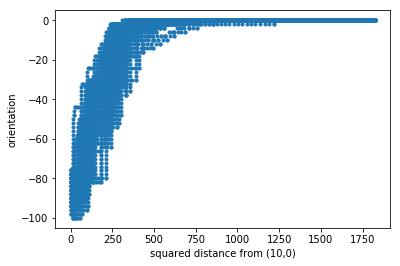

9595 5757


In [3]:
np.random.seed(2)
net = "orientation_regression"
action = {u'UP': 0, u'DOWN': 1, u'LEFT': 2, u'RIGHT': 3, u'No_Control': 4}
data = preprocess_raw("dataset_basic_103_trips.npy")
print("freq of each action after preprocessing: ",action_count(data[:,-1].astype(int)))

## visualize orientation of car vs its distance from (10,0)
orientation_vs_dist(data[:,0], data[:,1], data[:,17])

X, Y = extract_features_labels(data, net)
train_test_ratio = 0.6
train_max = np.round(len(X)*train_test_ratio).astype(int)
print(len(X), train_max)
X_train = X[:train_max,:]
Y_train = Y[:train_max,:]
X_test = X[train_max:,:]
Y_test = Y[train_max:,:]

if net == "orientation_regression":
    ## since we need to do polynomial regression, we extract polynomial features
    ## note that linear regression might work too but not with a great accuracy
    ## try by commenting this section
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train = poly.fit_transform(X_train)
    poly_params = poly.get_params()
    np.save("./params/poly_params.npy", poly_params)
    X_test = poly.transform(X_test)

X_train, X_test, min_scale, max_scale = min_max_scaling(X_train, X_test)
np.save("./params/min_scale.npy", min_scale)
np.save("./params/max_scale.npy", max_scale)

In [4]:
# model parameters
if(net == "mlp_all_labels"):
    n_hidden = 9
    out_dimn = 5
elif net == "orientation_regression":
    n_hidden = 0
    out_dimn = 1
batch_size = 32
n_train = 10000 
n_test =1000
n_epochs= 200
predict_every = 20
log_interval = 1000

print("Defining model")
model, optimizer, criterion = make_model(inp_dimn=X_train.shape[1], out_dimn=out_dimn, net=net, n_hidden=n_hidden)

print("Setting up data")
# Y_train = Y_train.squeeze(1)
trainset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train),torch.FloatTensor(Y_train))
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=2)
testset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test),torch.FloatTensor(Y_test))
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

print("Training model")
for epoch in range(n_epochs):
#     print("(Outer) Epoch ",epoch," of ",n_epochs,":")
    train(model, epoch, trainloader, criterion, optimizer)
print("Training Done")

Defining model
Setting up data
Training model
Train Epoch: 0 [0/5757 (0%)]	Loss: 1041.825928
Train Epoch: 1 [0/5757 (0%)]	Loss: 13.248693
Train Epoch: 2 [0/5757 (0%)]	Loss: 5.516094
Train Epoch: 3 [0/5757 (0%)]	Loss: 4.249793
Train Epoch: 4 [0/5757 (0%)]	Loss: 3.033917
Train Epoch: 5 [0/5757 (0%)]	Loss: 5.415815
Train Epoch: 6 [0/5757 (0%)]	Loss: 3.041094
Train Epoch: 7 [0/5757 (0%)]	Loss: 5.069506
Train Epoch: 8 [0/5757 (0%)]	Loss: 10.115485
Train Epoch: 9 [0/5757 (0%)]	Loss: 9.712541
Train Epoch: 10 [0/5757 (0%)]	Loss: 3.928103
Train Epoch: 11 [0/5757 (0%)]	Loss: 10.338022
Train Epoch: 12 [0/5757 (0%)]	Loss: 6.280272
Train Epoch: 13 [0/5757 (0%)]	Loss: 5.098955
Train Epoch: 14 [0/5757 (0%)]	Loss: 3.645183
Train Epoch: 15 [0/5757 (0%)]	Loss: 10.388646
Train Epoch: 16 [0/5757 (0%)]	Loss: 6.253011
Train Epoch: 17 [0/5757 (0%)]	Loss: 7.763732
Train Epoch: 18 [0/5757 (0%)]	Loss: 2.308555
Train Epoch: 19 [0/5757 (0%)]	Loss: 4.524573
Train Epoch: 20 [0/5757 (0%)]	Loss: 3.005789
Train Epoch:

Train Epoch: 180 [0/5757 (0%)]	Loss: 4.598416
Train Epoch: 181 [0/5757 (0%)]	Loss: 1.671949
Train Epoch: 182 [0/5757 (0%)]	Loss: 3.324128
Train Epoch: 183 [0/5757 (0%)]	Loss: 1.205015
Train Epoch: 184 [0/5757 (0%)]	Loss: 1.060636
Train Epoch: 185 [0/5757 (0%)]	Loss: 0.584835
Train Epoch: 186 [0/5757 (0%)]	Loss: 1.636984
Train Epoch: 187 [0/5757 (0%)]	Loss: 3.930856
Train Epoch: 188 [0/5757 (0%)]	Loss: 1.904349
Train Epoch: 189 [0/5757 (0%)]	Loss: 2.264567
Train Epoch: 190 [0/5757 (0%)]	Loss: 1.545116
Train Epoch: 191 [0/5757 (0%)]	Loss: 1.519110
Train Epoch: 192 [0/5757 (0%)]	Loss: 2.524742
Train Epoch: 193 [0/5757 (0%)]	Loss: 3.495404
Train Epoch: 194 [0/5757 (0%)]	Loss: 1.947907
Train Epoch: 195 [0/5757 (0%)]	Loss: 0.949590
Train Epoch: 196 [0/5757 (0%)]	Loss: 2.571030
Train Epoch: 197 [0/5757 (0%)]	Loss: 1.121431
Train Epoch: 198 [0/5757 (0%)]	Loss: 5.421872
Train Epoch: 199 [0/5757 (0%)]	Loss: 2.233081
Training Done


In [6]:
print("Saving model")
torch.save(model.state_dict(),'./params/model_regression.pth')

m,_,_ = make_model(inp_dimn=X_train.shape[1], out_dimn=1, net=net, n_hidden=n_hidden) 
state = torch.load('./params/model_regression.pth')
m.load_state_dict(state)

acc = get_accuracy(model, X_train, Y_train, net)
acc = get_accuracy(model, X_test, Y_test, net)

Saving model
average error in degree: 0.9242361769279466
average error in degree: 1.1020198191373904


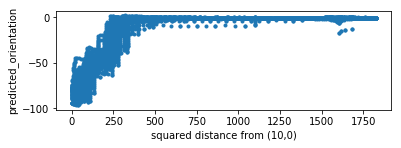

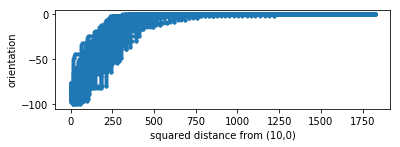

In [7]:
## let us visualize the predicted and true orientation vs distance plots
preds = predict(model, X_test)
ref = [10,0]
d = np.square(data[train_max:,0]-ref[0])+np.square(data[train_max:,1]-ref[1])
plt.figure(1)
plt.subplot(211)
plt.scatter(d,preds,marker='.')
plt.xlabel("squared distance from (10,0)")
plt.ylabel("predicted_orientation")
plt.show()

plt.subplot(212)
orientation_vs_dist(data[:,0], data[:,1], data[:,17])